In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
class DoubleDQNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DoubleDQNet, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        qvalue = self.fc3(x)
        return qvalue
    def get_action(self, input):
        qvalue = self.forward(input)
        _, action = torch.max(qvalue, 1)
        return action.numpy()[0]

def get_action(state, target_net, epsilon, env):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        return target_net.get_action(state)


In [17]:
def gen_param_array(l16_array):
    full = []
    for row in range(len(l16_array)):
        x = l16_array[row]
        arr_params = []
        
        for col in range(len(x)):
            list_params = list(params.values())[col]
            value = list_params[x[col]]
            arr_params.append(value)
        print(arr_params)
        full.append(arr_params)
    return full

In [18]:
def IQR(arr):
    # First quartile (Q1)
    Q1 = np.percentile(arr, 25, interpolation = 'midpoint')

    # Third quartile (Q3)
    Q3 = np.percentile(arr, 75, interpolation = 'midpoint')

    # Interquaritle range (IQR)
    IQR = Q3 - Q1
    return IQR

# Detrending

In [ ]:
def differencing(dataset,interval):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [ ]:
for i in range(16):
    arr = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    df = pd.DataFrame(arr)
    moving_ave = df.iloc[1:,0].rolling(50,min_periods=1).mean().values.flatten().tolist()
    diff = differencing(moving_ave,1)
    IQR_val = IQR(diff)
    print(f"Detrended Trial {i} IQR: {IQR_val}")
    x = np.array([i for i in range(len(diff))])
    fig = plt.figure(figsize = (10,10))
    plt.ylim((-1.5e3,1.5e3))
    plt.title(f"Trial {i}, IQR: {IQR_val}")
    plt.plot(x,diff)

In [ ]:
df_collate_detrend = pd.DataFrame([])
print("Run 1: During Learning Detrended Standard Deviations")
for i in range(len(params_array)):
    arr = params_array[i]
    
    arr_r = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    df = pd.DataFrame(arr_r)
    moving_ave = df.iloc[1:,0].rolling(50,min_periods=1).mean().values.flatten().tolist()
    diff = differencing(moving_ave,1)
    
    df_interest = pd.DataFrame(diff)
    df_collate_detrend = pd.concat([df_collate_detrend, df_interest], axis=1)
    
    print(f"Treatment {i}: Variance = {np.std(diff)}")


# Visualise All Plots

In [19]:
l16_array = np.array(pd.read_csv('L16.txt',header=None, sep='\t'))

In [20]:
params = {
 'lr' : [1e-04,1e-03,1e-02,1e-01],
 'gamma' : [0.80,0.90,0.95,0.99],
 'epsilon_decay': [1e-05,1e-04,1e-03,1e-02],
 'update_freq' : [50,100,150,200]
}

In [21]:
params_array = gen_param_array(l16_array)

[0.0001, 0.8, 1e-05, 50]
[0.0001, 0.9, 0.0001, 100]
[0.0001, 0.95, 0.001, 150]
[0.0001, 0.99, 0.01, 200]
[0.001, 0.8, 0.0001, 150]
[0.001, 0.9, 1e-05, 200]
[0.001, 0.95, 0.01, 50]
[0.001, 0.99, 0.001, 100]
[0.01, 0.8, 0.001, 200]
[0.01, 0.9, 0.01, 150]
[0.01, 0.95, 1e-05, 100]
[0.01, 0.99, 0.0001, 50]
[0.1, 0.8, 0.01, 100]
[0.1, 0.9, 0.001, 50]
[0.1, 0.95, 0.0001, 200]
[0.1, 0.99, 1e-05, 150]


In [22]:
params_df = pd.DataFrame(params_array, columns = ['lr','gamma','epsilon_decay','update_freq'])
#params_df.to_csv('params.csv')

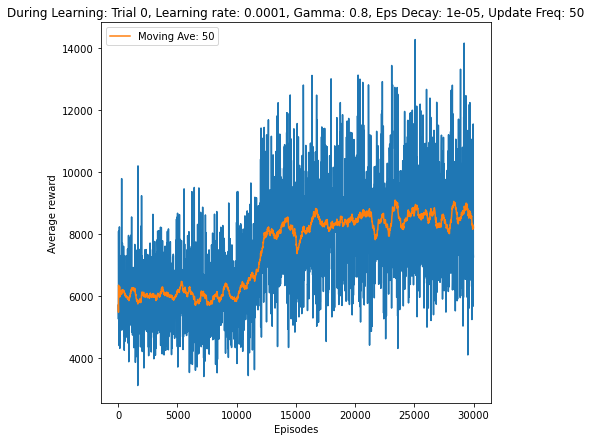

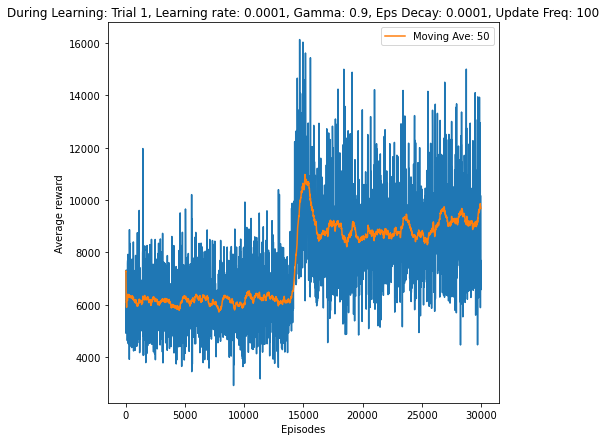

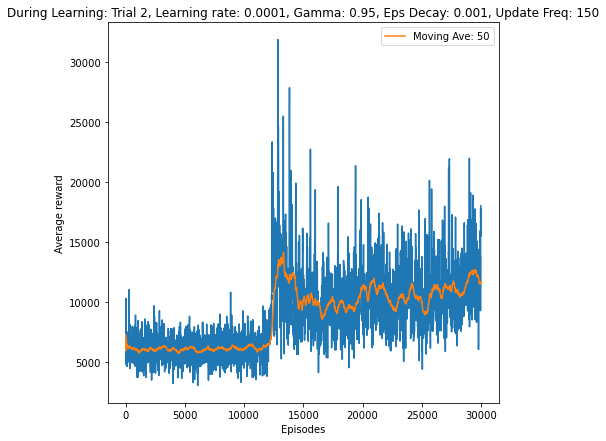

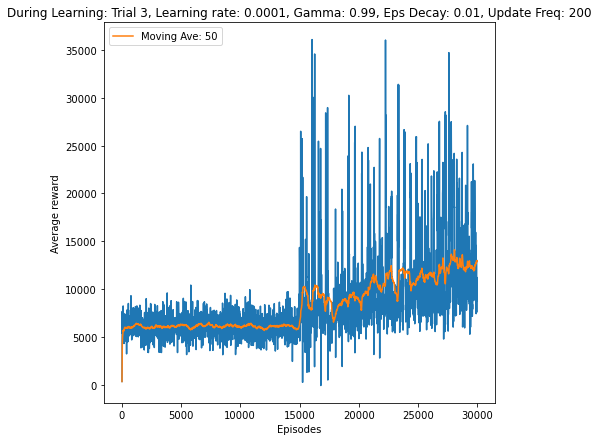

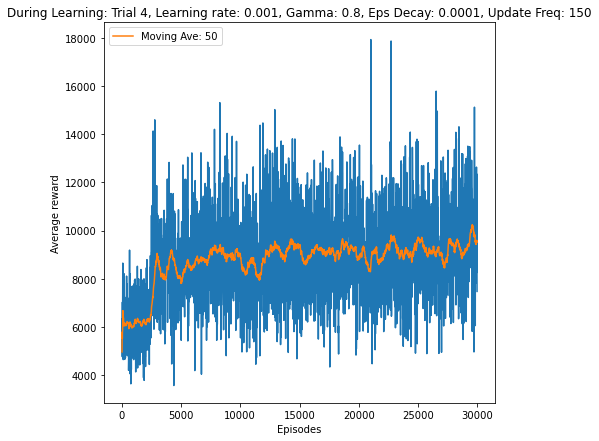

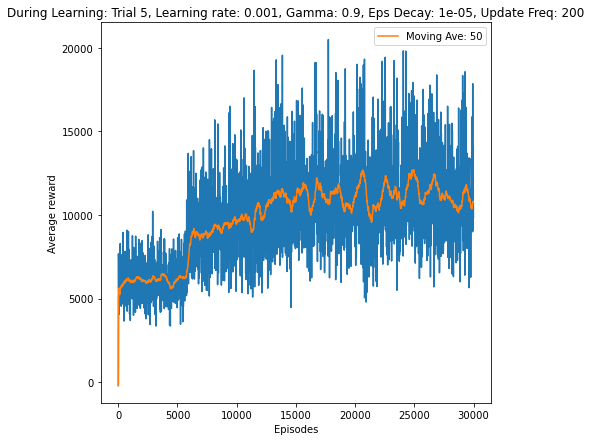

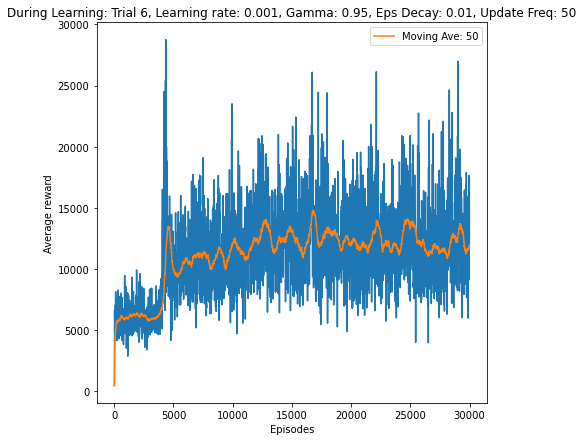

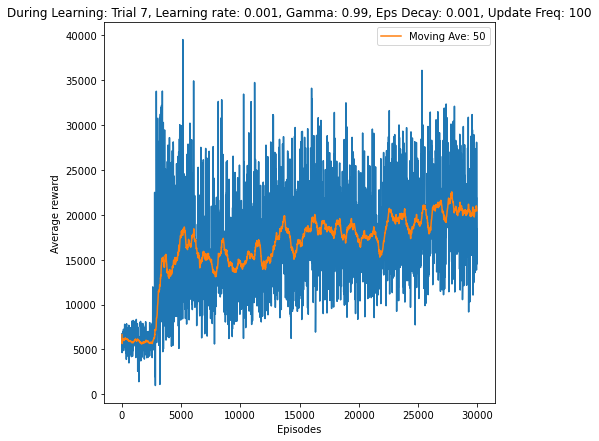

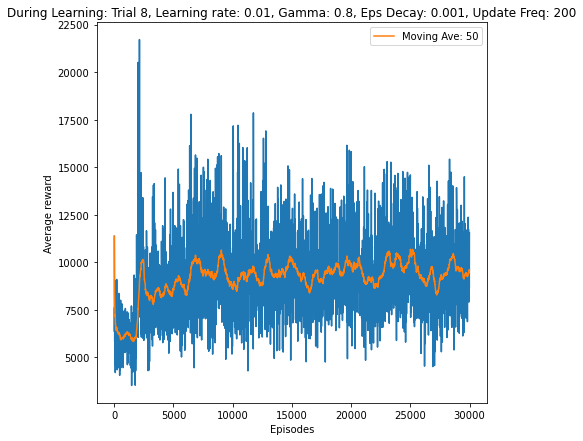

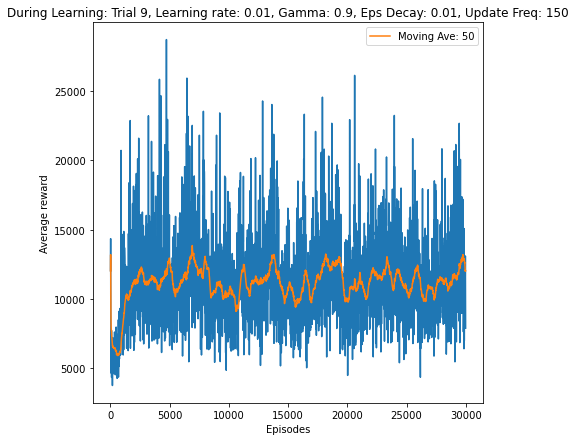

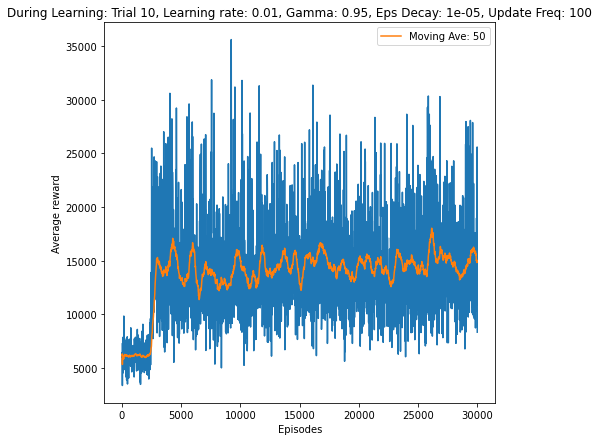

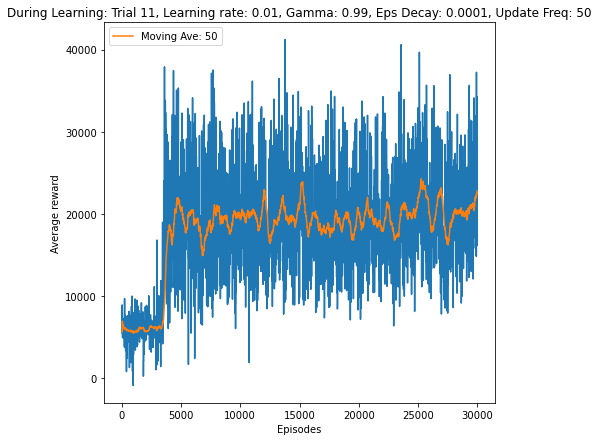

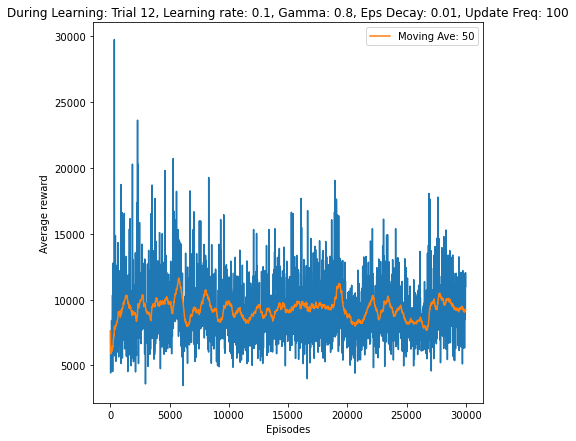

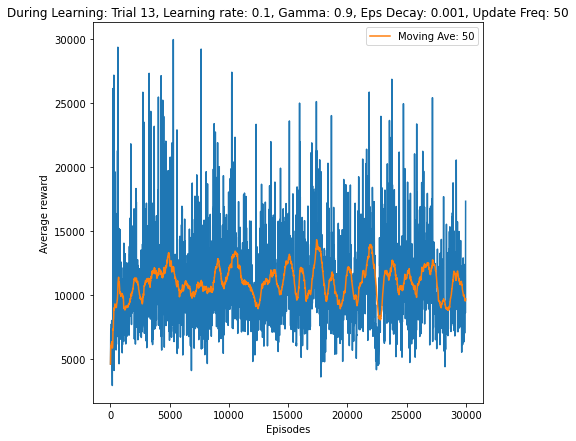

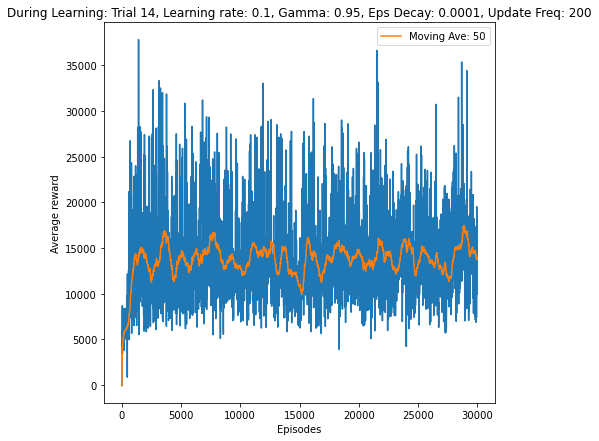

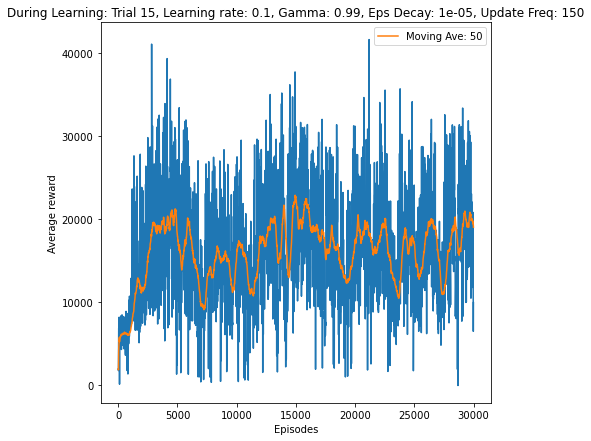

In [24]:
for i in range(len(params_array)):
    arr = params_array[i]
    fig = plt.figure(figsize=(7,7))
    plt.title(f"During Learning: Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
    data = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    
    df = pd.DataFrame(data)
    moving_ave = df.iloc[1:,0].rolling(50,min_periods=1).mean().values.flatten().tolist()
    
    plt.plot(data[1:,1],data[1:,0])
    plt.plot(data[1:,1],moving_ave,label = "Moving Ave: 50")
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Average reward')

# BoxPlot

In [23]:
df_collate = pd.DataFrame([])
for i in range(len(params_array)):
    arr = params_array[i]
    #fig = plt.figure(figsize=(10,10))
    #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
    data = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    
    df = pd.DataFrame(data)
    df_interest = df.iloc[:,0]
    df_collate = pd.concat([df_collate, df_interest], axis=1)
    

In [24]:
df_collate.columns = [f"Trial {x}" for x in range(16)]

In [25]:
df_collate = df_collate.drop(0)
df_collate

Trial 0  Trial 1  Trial 2  Trial 3  Trial 4  Trial 5  Trial 6  Trial 7  \
1      5710.0   7280.0   7300.0    355.0   4955.0   -205.0    475.0   6655.0   
2      5265.0   7315.0   5430.0   3700.0   6050.0   7675.0   1070.0   4655.0   
3      8095.0   6000.0   5195.0   7675.0   6330.0   7300.0   6605.0   5745.0   
4      6270.0   4915.0  10320.0   5390.0   4755.0   5640.0   5525.0   6165.0   
5      5505.0   4980.0   5985.0   6075.0   7025.0   5845.0   5100.0   6820.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
2995   8985.0   5890.0  13850.0  10550.0   8245.0  13965.0   9125.0  28050.0   
2996   5680.0  10175.0   9305.0   7590.0  12350.0  10025.0  17635.0  21005.0   
2997  11550.0   6565.0  17815.0  11225.0  11055.0   9040.0  13795.0  14505.0   
2998   7355.0   7685.0  15485.0   8725.0   7960.0  10545.0  17530.0  16625.0   
2999   7270.0   7690.0  18035.0  10680.0   7470.0   9865.0  11630.0  18365.0   

      Trial 8  Trial 9  Trial 10  Trial 11  Trial 12  Trial 13  Trial 14  \
1     11365.0  12025.0    6170.0    5730.0    7605.0    4610.0     -35.0   
2      6350.0  14345.0    6450.0    5495.0    4430.0    6190.0    2415.0   
3      7620.0   5985.0    3365.0    8905.0    6530.0    7315.0    5750.0   
4      5795.0   4650.0    7310.0    7585.0    4985.0    5550.0    8685.0   
5      6975.0   5410.0    5930.0    6800.0    7215.0    6165.0    3450.0   
...       ...      ...       ...       ...       ...       ...       ...   
2995  11450.0  11215.0   17140.0   21650.0    8490.0   12415.0    9335.0   
2996  10940.0  11655.0   13405.0   26165.0    9345.0   11540.0   19525.0   
2997   9535.0  13095.0   10855.0   16125.0    9415.0    8605.0   18095.0   
2998   8650.0   9320.0   25600.0   34250.0   12055.0   10740.0   18425.0   
2999  11555.0   7880.0    8335.0   26655.0   11010.0   17345.0    9990.0   

      Trial 15  
1       1865.0  
2       1700.0  
3       6370.0  
4       6810.0  
5       6830.0  
...        ...  
2995   20580.0  
2996   15760.0  
2997   14285.0  
2998    6435.0  
2999    9895.0  

[2999 rows x 16 columns]

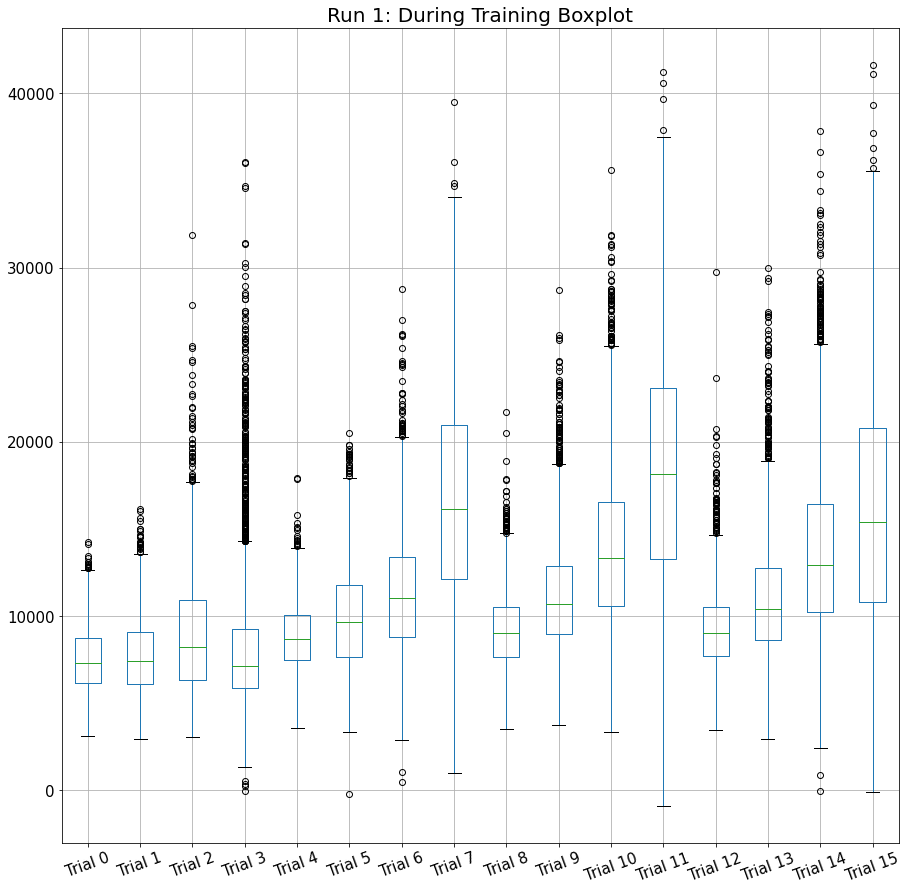

In [26]:
fig = plt.figure(figsize=(15,15))
plt.title("Run 1: During Training Boxplot",fontsize = 20)
ax = df_collate.boxplot(grid=True, rot=20, fontsize=15)
plt.show()

# Mean & Standard Dev

During Learning

In [ ]:
variance_weight = 1
for i in range(len(params_array)):
    arr = params_array[i]
    
    data = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    df = pd.DataFrame(data)
    moving_ave = np.array(df.iloc[:,0].rolling(50,min_periods=1).mean().values.flatten())
    Mean = round(np.mean(moving_ave),2)
    Std = round(np.std(moving_ave),2)
    iqr = round(IQR(moving_ave),2)
    Mean_last_n = np.mean(df.iloc[-100:,0])
    
    print(f"Total Trial {i}, Mean: {Mean}, Std Dev: {Std}, Mean last 100: {Mean_last_n} SNR: {Mean/(variance_weight*Std)}, IQR: {iqr}")
#     for j in range(3):
#         Mean_third = round(np.mean(moving_ave[1000*j:1000*(j+1)]),2)
#         Std_third = round(np.std(moving_ave[1000*j:1000*(j+1)]),2)
#         iqr_third = round(IQR(moving_ave[1000*j:1000*(j+1)]),2)
#         print(f"Quatile {j+1} Trial {i}, Mean: {Mean_third}, Std Dev: {Std_third}, SNR: {Mean_third/(variance_weight*Std_third)}, IQR: {iqr_third}")
    
    print()

In [ ]:
def gradient(arr,window):
    gradient_arr = []
   
    for i in range(len(arr)):
        if i < window:
            continue
          
        y = arr[i-window:i+1,0]
        x = arr[i-window:i+1,1]
        grad, b = np. polyfit(x, y, 1)
        gradient_arr.append([grad,b])
    return gradient_arr

In [ ]:
gradient(test_2,100)[1400:]

# After Learning Evaluation

In [8]:
from machine import Machine
from GymMachEnv import MachineEnv

In [9]:
def compute_avg_return(environment, policy, num_episodes):
    total_return = 0.0
    for _ in range(num_episodes):
        state = torch.Tensor(environment.reset())
        state = state.unsqueeze(0)
        episode_return = 0.0 
        while not environment.done:
            action = get_action(state, policy, 0.1, environment)
            next_state, reward, done, _ = environment.step(action)
            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)
            state = next_state
            episode_return += reward
        total_return += episode_return   
    avg_return = total_return / num_episodes
    return avg_return# Evaluate the agent's policy once before training.

In [10]:
def evaluate(env,agent):
    episodic_rewards = []
    trials = 500
    
    
    for t in range(trials):
        episodic_rewards.append(compute_avg_return(env,agent,20))
        #print(episodic_rewards[-1])
        
    return np.array(episodic_rewards)


In [30]:
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)

# runs = ['eval_1','eval_2','eval_3']


# for x in runs:
#     for i in range(16):
#         model = torch.load(f'run_1/trial_{i}_dqn_agent_.pt')
#         model.eval()
#         parameters = params_array[i]
#         result = evaluate(env,model)
#         np.savetxt(f'run_1/{x}/evaluated_trial_{i}.txt', result, delimiter=',',fmt='%s')



# Processing Data

In [12]:
runs = ['eval_1','eval_2','eval_3']
df_total = pd.DataFrame()

for x in runs:
    mean_arr = []
    for i in range(16):
        mean_arr.append(np.mean(np.loadtxt(f'run_1/{x}/evaluated_trial_{i}.txt')))
    df= pd.DataFrame(mean_arr)
    df_total= pd.concat([df_total,df],axis=1)

# df_total.columns = runs
# df_total['average'] = df_total.mean(axis=1)
# df_total = pd.concat([params_df,df_total],axis=1)
# df_total.to_csv('results.csv')

# Visualise After Learning

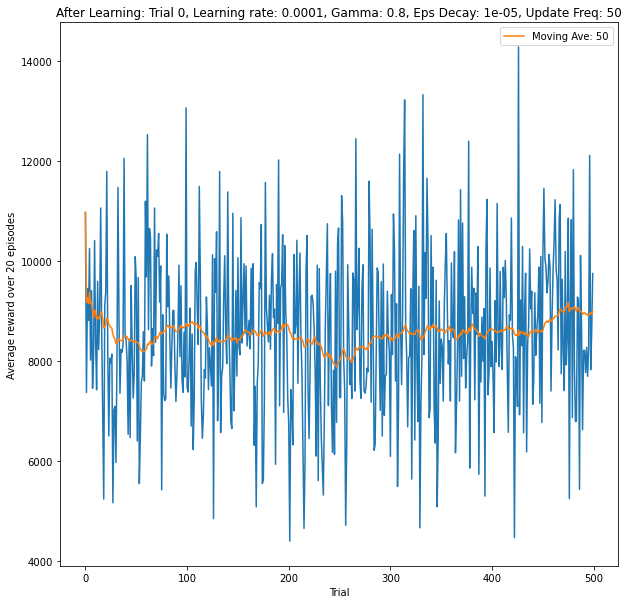

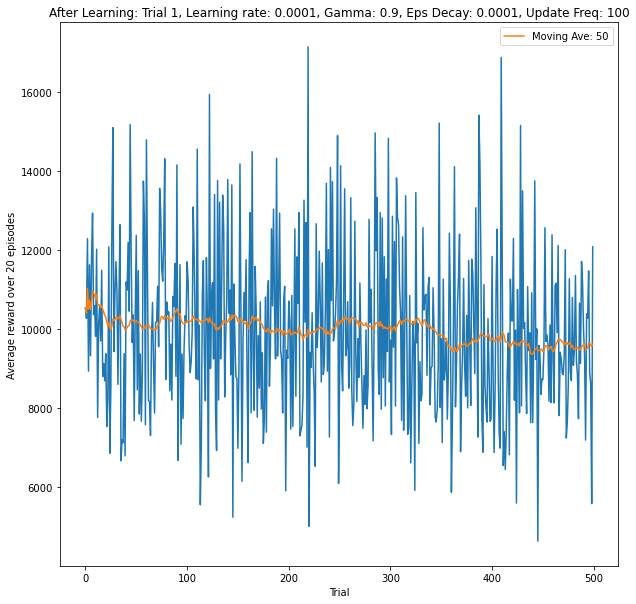

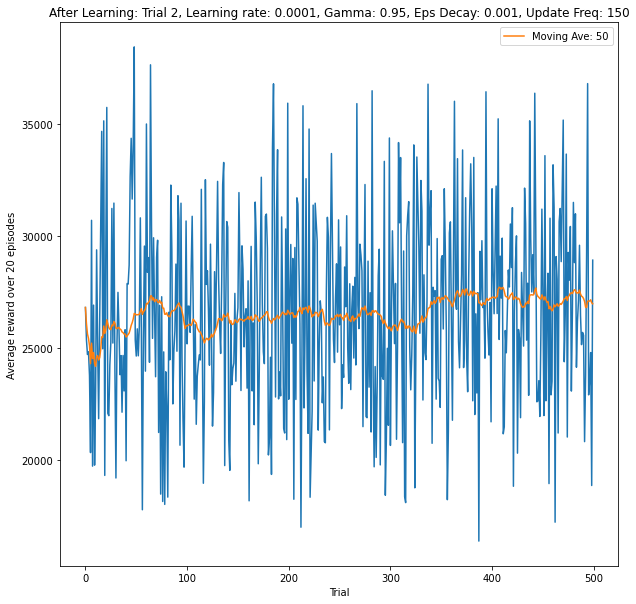

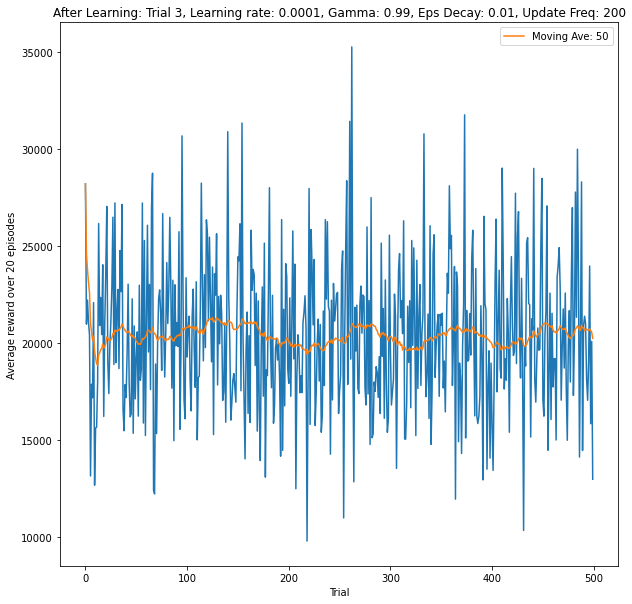

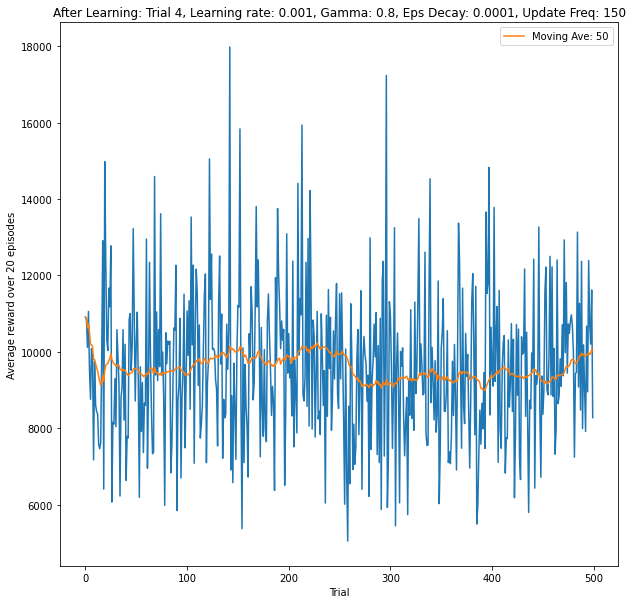

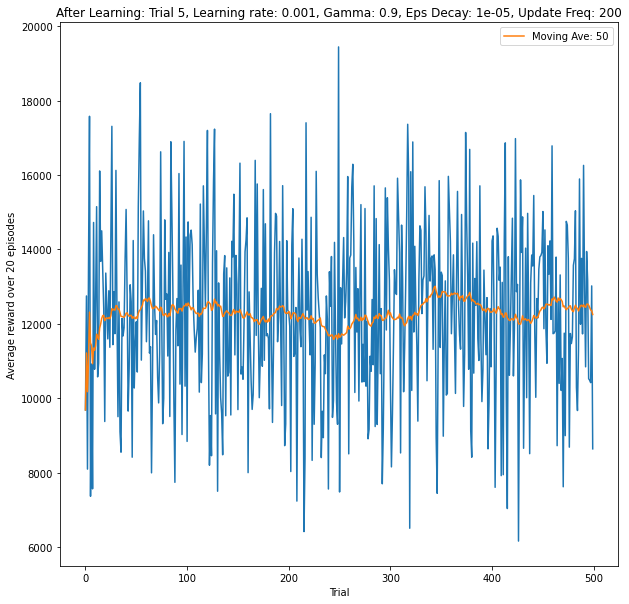

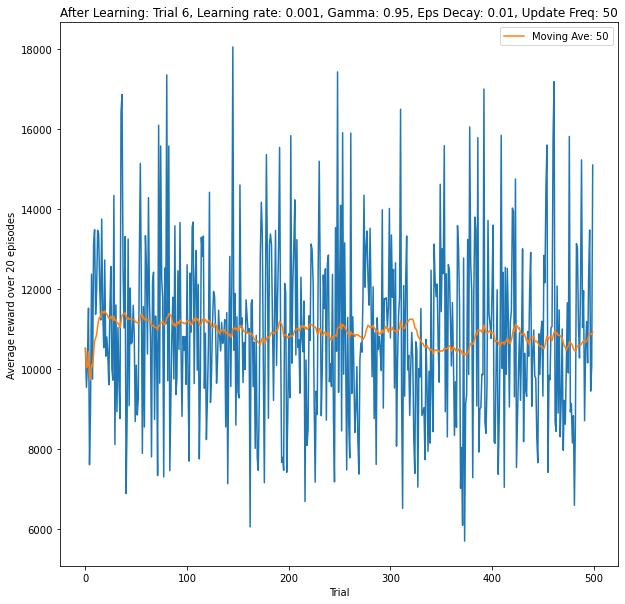

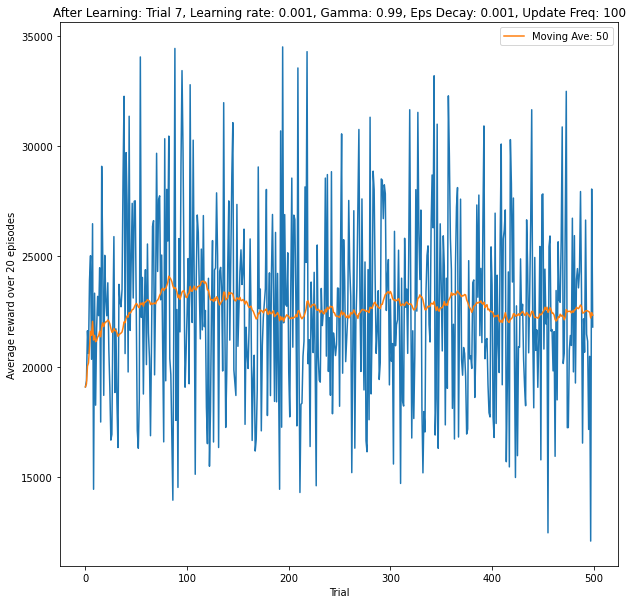

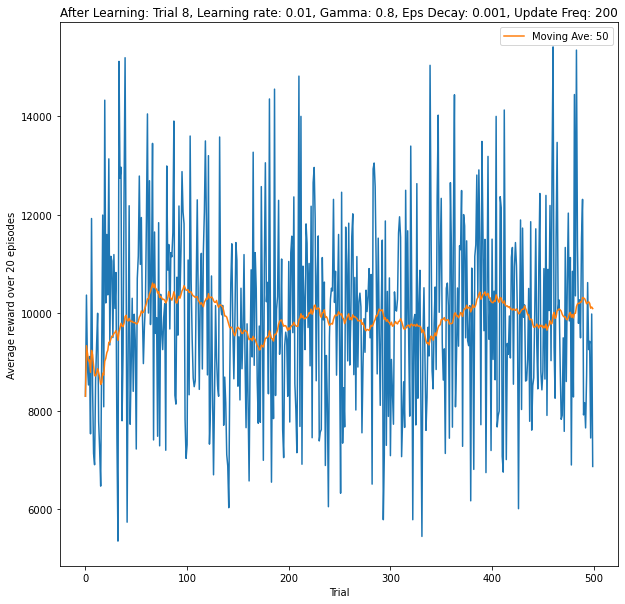

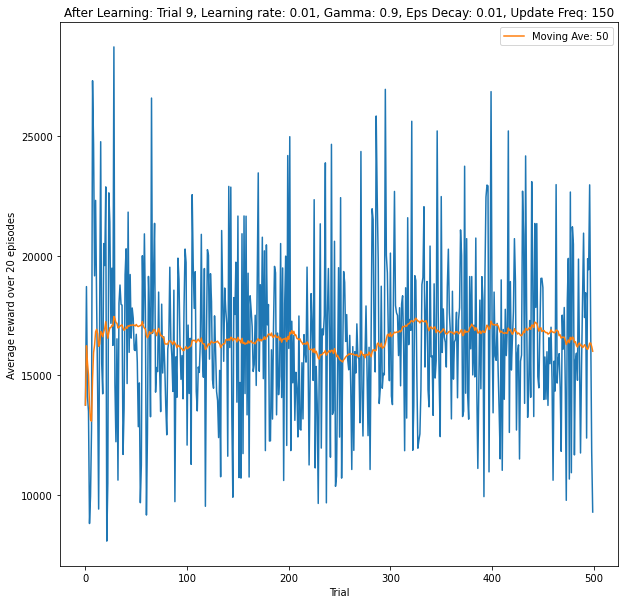

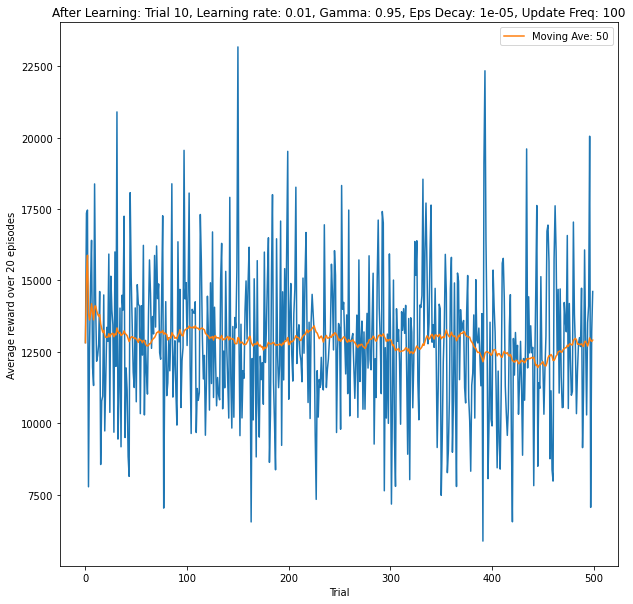

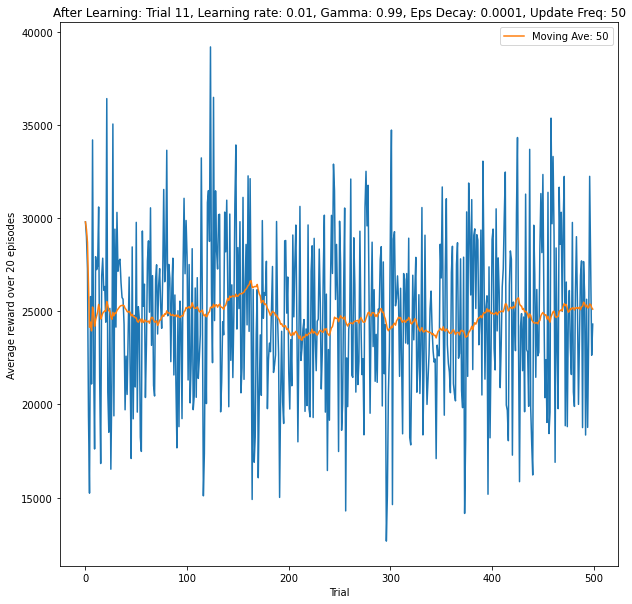

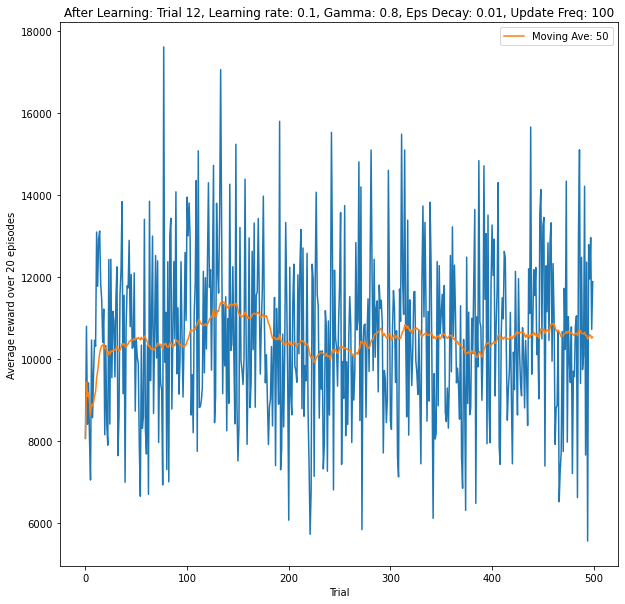

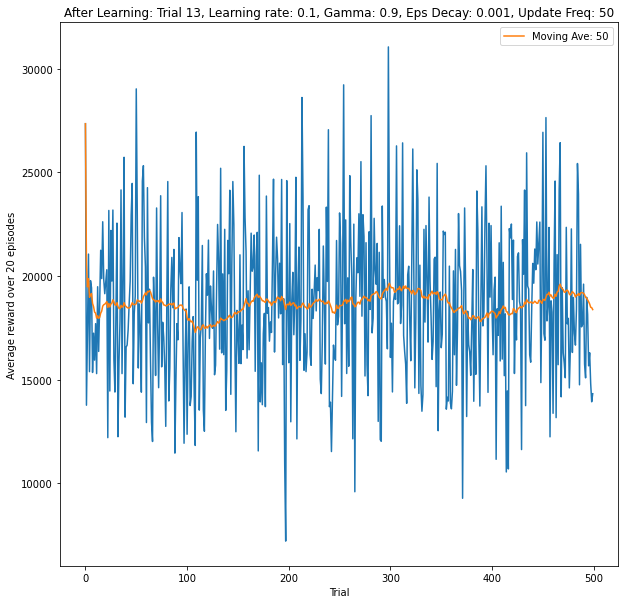

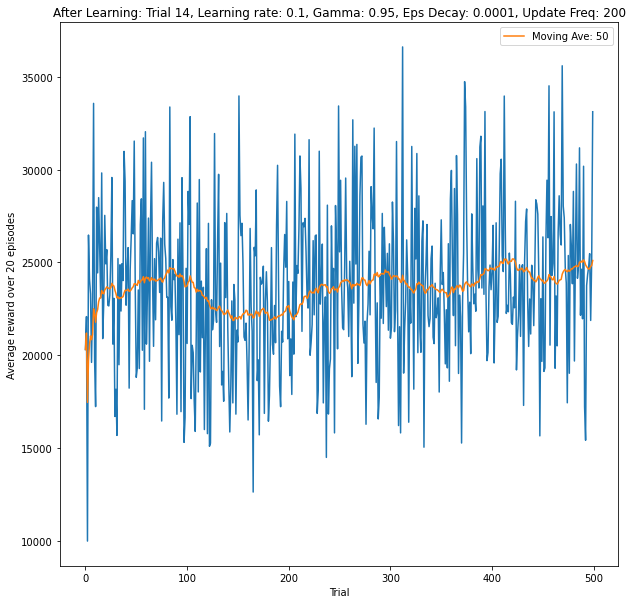

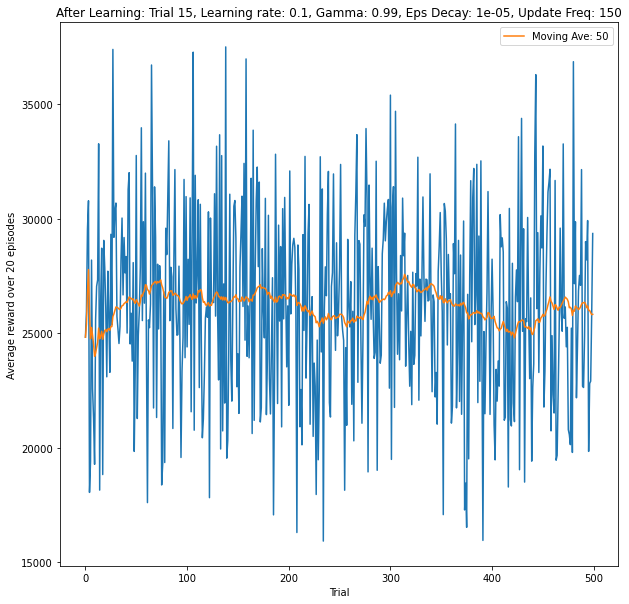

In [11]:
for i in range(len(params_array)):
    arr = params_array[i]
    
    data = np.loadtxt(f"run_1/eval_1/evaluated_trial_{i}.txt")
    df = pd.DataFrame(data)
    ep = [x for x in range(len(data))]
    moving_ave = np.array(df.rolling(50,min_periods=1).mean().values.flatten())
    
    fig = plt.figure(figsize=(10,10))
    plt.title(f"After Learning: Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
    plt.plot(ep,data)
    plt.plot(ep,moving_ave,label = "Moving Ave: 50")
    plt.legend()
    plt.xlabel('Trial')
    plt.ylabel('Average reward over 20 episodes')
    plt.show()

Average

In [ ]:
dict_run = {i:[] for i in range(16)}
runs = ['eval_1','eval_2','eval_3']
weight_var = 1
for eval in runs:
    print(eval)
    for i in range(len(params_array)):
        arr = params_array[i]
        data = np.loadtxt(f"run_1/{eval}/evaluated_trial_{i}.txt")
        mean = np.mean(data)
        dict_run[i].append(mean)
        
        std = np.std(data)
        median = np.median(data)
        IQR_ = IQR(data)
        if mean < 10000: continue
        print(f"Trial {i}, Mean: {round(mean,2)}, Std: {round(std,2)}, SNR: {round(mean/(weight_var*std),2)}, Median: {round(median,2)}, IQR: {round(IQR_,2)}, Median/IQR: {round(median/(weight_var*IQR_),2)}")
    print()
    
for key, value in dict_run.items():
    arr_np=np.array(value)
    print(f"Average Mean for Trial {key}: {np.mean(arr_np)}")

<Figure size 720x720 with 0 Axes>

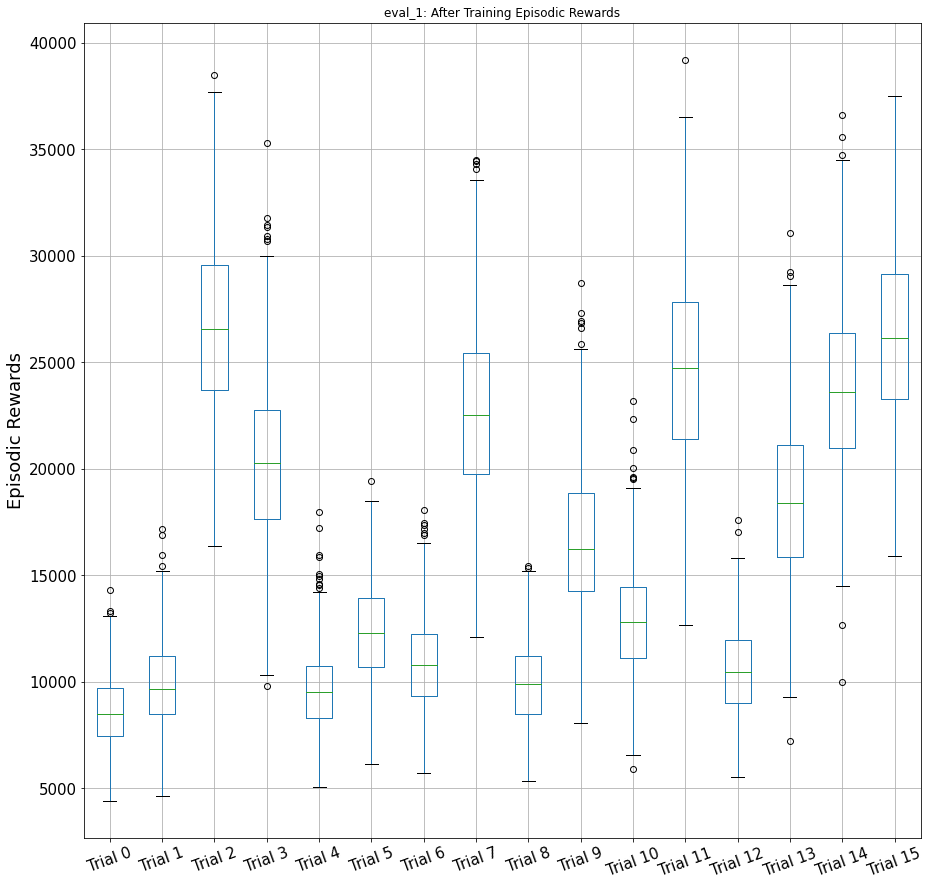

<Figure size 720x720 with 0 Axes>

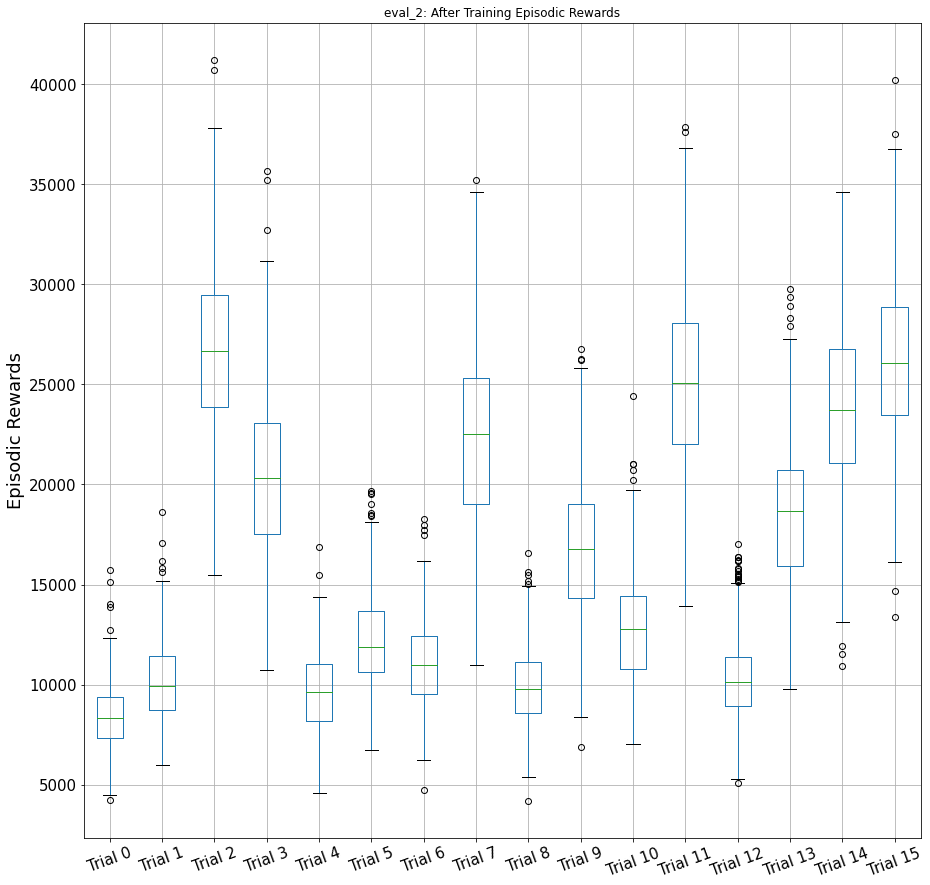

<Figure size 720x720 with 0 Axes>

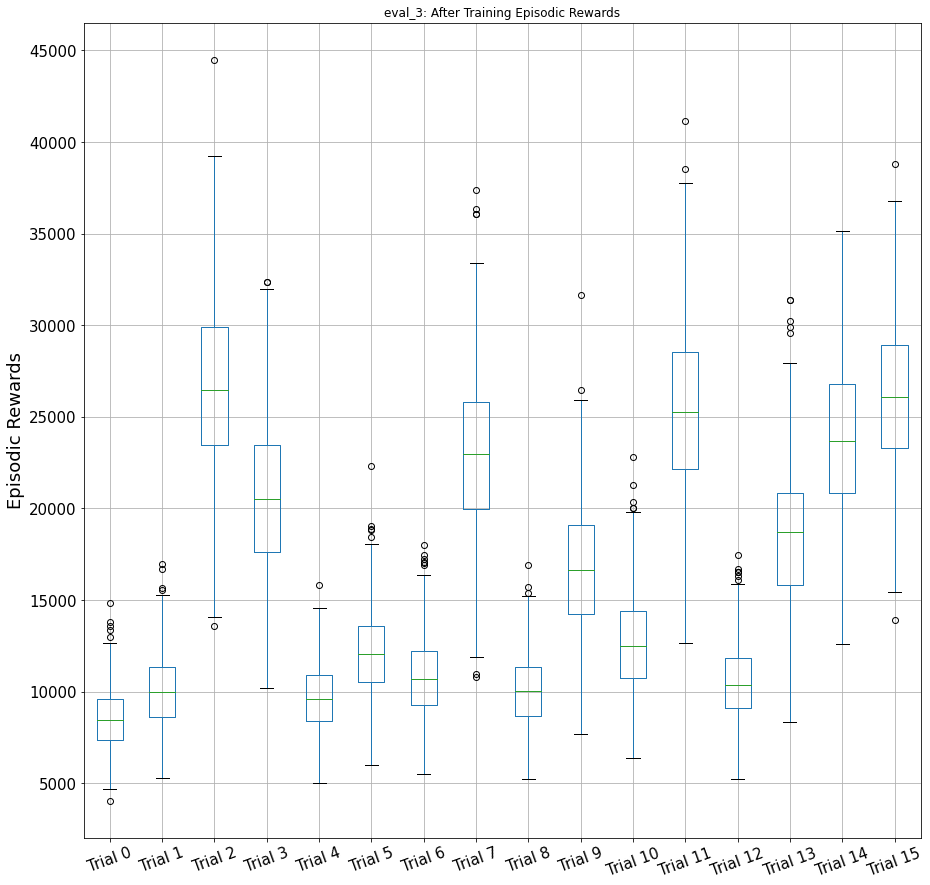

In [14]:
for x in runs:
    df_collate_all = pd.DataFrame([])
    fig = plt.figure(figsize=(10,10))
    for i in range(len(params_array)):
        arr = params_array[i]
        #fig = plt.figure(figsize=(10,10))
        #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
        data = np.loadtxt(f"run_1/{x}/evaluated_trial_{i}.txt")
        df = pd.DataFrame(data)
        df_collate_all = pd.concat([df_collate_all, df], axis=1)
    
    
    df_collate_all.columns = [f"Trial {x}" for x in range(16)]
    fig = plt.figure(figsize=(15,15))
    plt.title("Run 1: During Training Boxplot",fontsize = 20)
    ax = df_collate_all.boxplot(grid=True, rot=20, fontsize=15)
    plt.title(f'{x}: After Training Episodic Rewards')
    plt.ylabel('Episodic Rewards',fontsize=18)
    plt.show()

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

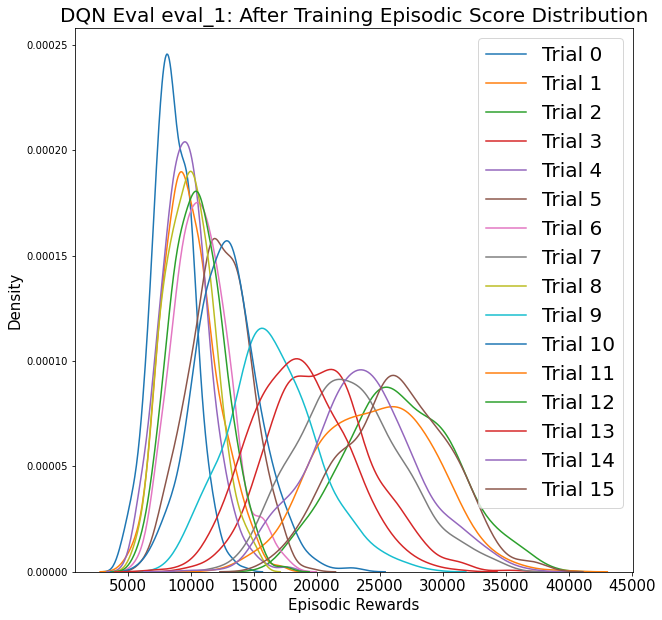

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

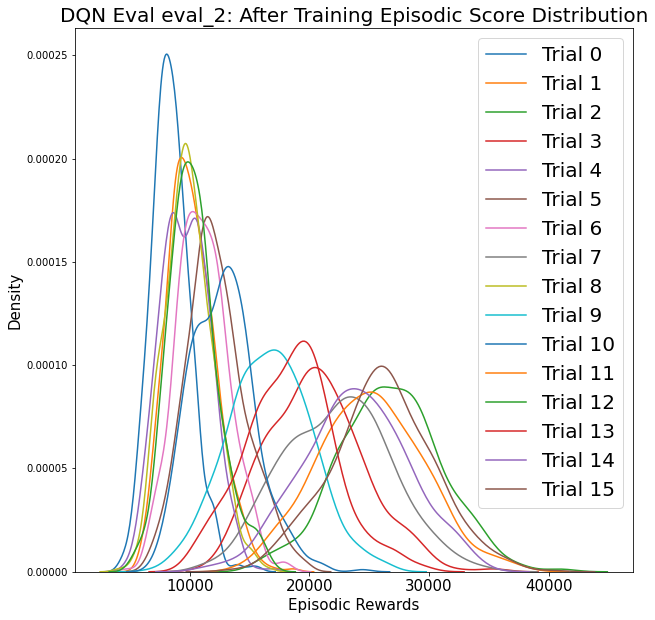

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

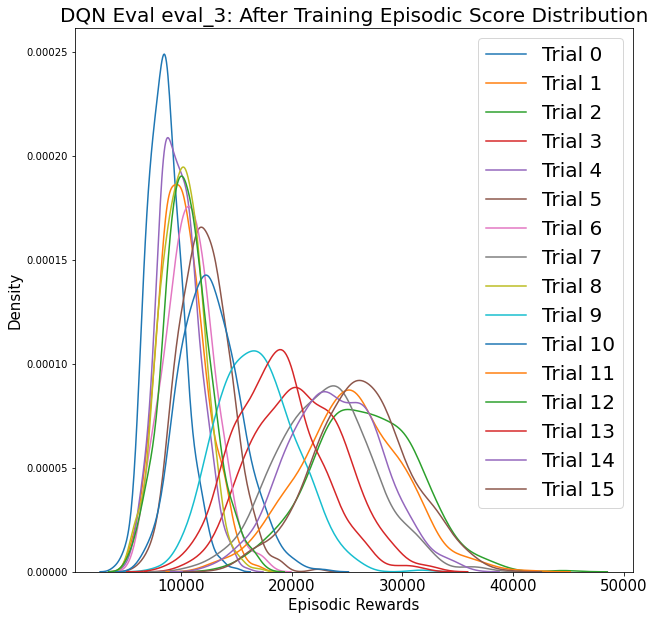

In [26]:
import seaborn as sns
runs = ['eval_1','eval_2','eval_3']
for x in runs:
    fig = plt.figure(figsize=(10,10))
    for i in range(len(params_array)):
        arr = params_array[i]
        #fig = plt.figure(figsize=(10,10))
        #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
        data = np.loadtxt(f"run_1/{x}/evaluated_trial_{i}.txt")

        df_interest = pd.DataFrame(data)
        ax = sns.distplot(df_interest,hist=False,label=f"Trial {i}")
    plt.legend(prop={'size': 20})
    plt.title(f"DQN Eval {x}: After Training Episodic Score Distribution",fontsize=20)
    plt.xlabel("Episodic Rewards",fontsize=15)
    plt.ylabel("Density",fontsize=15)
    plt.xticks(fontsize= 15)
    plt.show()

Moving Average

In [ ]:
runs = ['eval_1','eval_2','eval_3']
weight_var = 1
for eval in runs:
    print(eval)
    for i in range(len(params_array)):
        arr = params_array[i]
        data = np.loadtxt(f"run_1/{eval}/evaluated_trial_{i}.txt")
        df = pd.DataFrame(data)
        moving_ave = np.array(df.rolling(50,min_periods=1).mean().values.flatten())
        mean = np.mean(moving_ave)
        std = np.std(moving_ave)
        median = np.median(moving_ave)
        IQR_ = IQR(moving_ave)
        if mean < 10000: continue
        print(f"Trial {i}, Mean: {round(mean,2)}, Std: {round(std,2)}, SNR: {round(mean/(weight_var*std),2)}, Median: {round(median,2)}, IQR: {round(IQR_,2)}, Median/IQR: {round(median/(weight_var*IQR_),2)}")
    print()

In [ ]:
df_collate_fp = pd.DataFrame([])
for i in range(len(params_array)):
    arr = params_array[i]
    #fig = plt.figure(figsize=(10,10))
    #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
    data = np.loadtxt(f"run_1/eval_1/evaluated_trial_{i}.txt")
    
    df_interest = pd.DataFrame(data)
    df_collate_fp = pd.concat([df_collate_fp, df_interest], axis=1)

In [ ]:
df_collate_fp.columns = [f"Trial {x}" for x in range(16)]


In [ ]:
fig = plt.figure(figsize=(15,15))
plt.title("Run 1: After Training Boxplot",fontsize = 20)
ax = df_collate_fp.boxplot(grid=True, rot=20, fontsize=15)
plt.show()

# Taguchi Optimised Parameters

In [33]:
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)

model = torch.load('best/trial_0_dqn_agent_.pt')

arr = evaluate(env,model)
np.savetxt(f'best/evaluated_trial_0.txt', arr, delimiter=',',fmt='%s')

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Params: Lr, Gamma, Eps Decay, Update freq:  [0.1, 0.99, 0.001, 150]


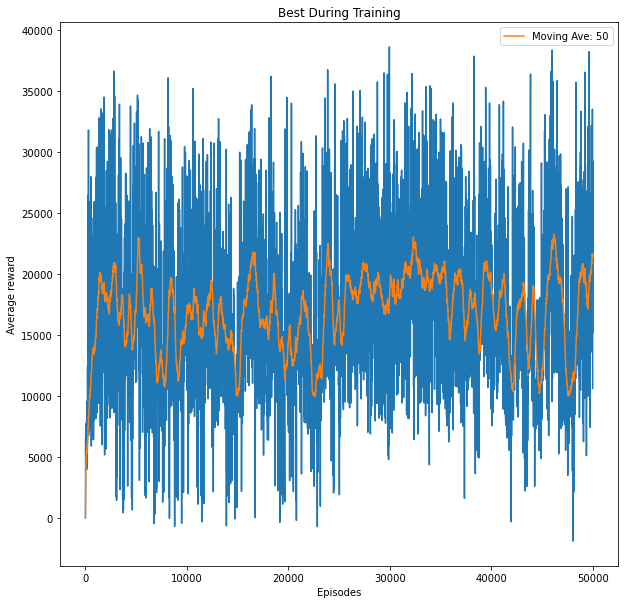

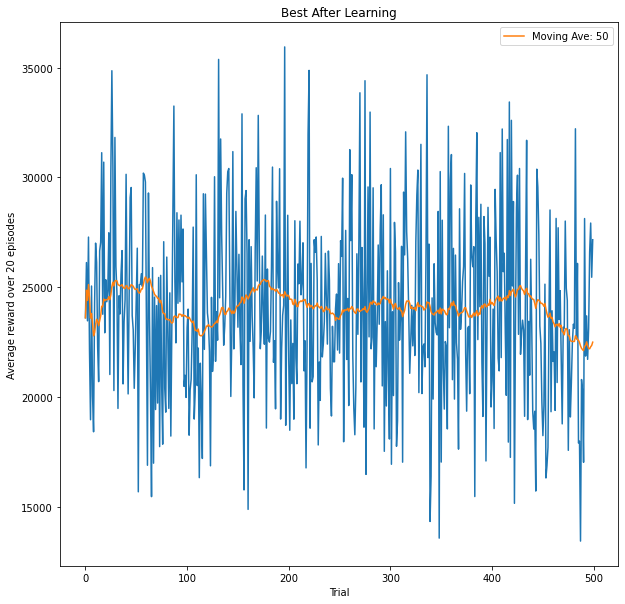

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


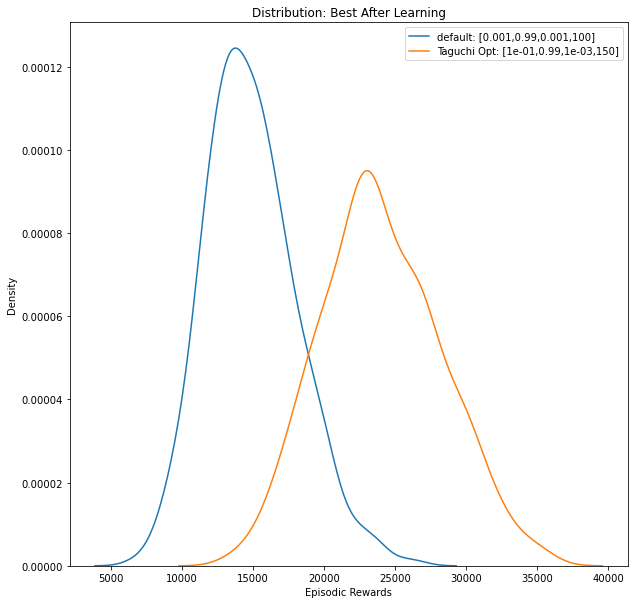

In [40]:
print("Params: Lr, Gamma, Eps Decay, Update freq: ",[1e-01,0.99,1e-03,150])

data = np.array(pd.read_csv('best/trial_0.txt',header=None))

df = pd.read_csv('best/trial_0.txt',header=None)
moving_ave = df.iloc[:,0].rolling(50,min_periods=1).mean().values.flatten().tolist()

fig = plt.figure(figsize=(10,10))
plt.plot(data[:,1],data[:,0])
plt.plot(data[:,1],moving_ave,label = "Moving Ave: 50")
#plt.plot(data_eval[1:,1],eval_moving_ave,label="Eval Moving Ave: 50")
plt.title('Best During Training')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.show()



data = np.loadtxt(f"best/evaluated_trial_0.txt")
df = pd.DataFrame(data)
ep = [x for x in range(len(data))]
moving_ave = np.array(df.rolling(50,min_periods=1).mean().values.flatten())
fig = plt.figure(figsize=(10,10))
plt.title(f"Best After Learning")
plt.plot(ep,data)
plt.plot(ep,moving_ave,label = "Moving Ave: 50")
plt.legend()
plt.xlabel('Trial')
plt.ylabel('Average reward over 20 episodes')
plt.show()

fig = plt.figure(figsize=(10,10))
plt.title(f"Distribution: Best After Learning")
data = np.loadtxt("default/test_trial.txt")
df_default = pd.DataFrame(data)
ax = sns.distplot(df_default,hist=False,label=f"default: [0.001,0.99,0.001,100]")
ax = sns.distplot(df,hist=False,label=f"Taguchi Opt: [1e-01,0.99,1e-03,150]")
plt.xlabel('Episodic Rewards')
plt.legend()
plt.show()